Imports

In [ ]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras
import nltk
from collections import defaultdict
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import regex
import matplotlib.pyplot as plt
from copy import deepcopy
np.random.seed(1234)
tf.random.set_seed(1234)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hamil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Preprocessing

In [ ]:
def remove_noise(line:str):
  line = line.replace("<br /><br />","") #gets rid of <br />
  line = regex.sub("[^a-z0-9 ]"," ",line) #get rid of all non lowercase/numerical values and replaces with a space
  line = regex.sub("[ ]{2,}"," ",line)   #replaces all occurances of multiple spaces with just one space
  return line


def get_data(file):
  stop_words = stopwords.words('english')
  sw = defaultdict(lambda:1)
  for word in stop_words:
    sw[word]=0
  f = open(file)
  ps = PorterStemmer()
  reviews = []
  sentiments = []
  for line in f.readlines():
    splitter = line.rindex(",")
    review,sentiment = (line[:splitter],line[splitter+1:-1])
    #make lower
    review = review.lower()
    #remove noise
    review = remove_noise(review)
    #stem and stopword removal
    review = [ps.stem(word) for word in review.split(" ") if sw[word]]
    review = " ".join(review)
    reviews.append(review[1:-1])#append tokenized data
    if(sentiment=='positive'):
      sentiments.append(1)
    else:
      sentiments.append(0)
    #sentiments.append(sentiment)
  return reviews[1:],sentiments[1:]

In [ ]:
reviews,sentiments = get_data("Assignment_2_modified_ Dataset.csv")

In [ ]:
print(reviews[1])
print(reviews[0])
print(sentiments[1])
print(sentiments[0])

wonder littl product film techniqu unassum old time bbc fashion give comfort sometim discomfort sens realism entir piec actor extrem well chosen michael sheen got polari voic pat truli see seamless edit guid refer william diari entri well worth watch terrificli written perform piec master product one great master comedi life realism realli come home littl thing fantasi guard rather use tradit dream techniqu remain solid disappear play knowledg sens particularli scene concern orton halliwel set particularli flat halliwel mural decor everi surfac terribl well done
one review mention watch 1 oz episod hook right exactli happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home mani aryan muslim gangsta lat

Split into Train Val Test(80,10,10)

In [ ]:
trainCut = int(len(reviews)*0.8)
valCut = int(len(reviews)*0.9)
train_data = reviews[0:trainCut]
train_labels = sentiments[0:trainCut]
val_data = reviews[trainCut:valCut]
val_labels = sentiments[trainCut:valCut]
test_data = reviews[valCut:]
test_labels= sentiments[valCut:]


In [ ]:
tokenizer = keras.preprocessing.text.Tokenizer(filters="", lower=False, split=' ', oov_token='OOV')

In [ ]:
tokenizer.fit_on_texts(train_data)

In [ ]:
tokenizer.get_config()

{'num_words': None,
 'filters': '',
 'lower': False,
 'split': ' ',
 'char_level': False,
 'oov_token': 'OOV',
 'document_count': 40000,
 'word_counts': '{"one": 44152, "review": 3445, "mention": 2406, "watch": 22248, "1": 3364, "oz": 258, "episod": 3885, "hook": 473, "right": 5637, "exactli": 1599, "happen": 5754, "first": 13909, "thing": 13146, "struck": 223, "brutal": 744, "unflinch": 22, "scene": 17109, "violenc": 1701, "set": 6381, "word": 2975, "go": 14577, "trust": 589, "show": 15915, "faint": 95, "heart": 2657, "timid": 41, "pull": 1491, "punch": 449, "regard": 791, "drug": 1473, "sex": 2765, "hardcor": 187, "classic": 3432, "use": 8181, "call": 4608, "nicknam": 65, "given": 2850, "oswald": 29, "maximum": 87, "secur": 387, "state": 1663, "penitentari": 2, "focus": 738, "mainli": 616, "emerald": 13, "citi": 2043, "experiment": 169, "section": 378, "prison": 1155, "cell": 407, "glass": 423, "front": 996, "face": 3698, "inward": 10, "privaci": 19, "high": 3455, "agenda": 154, "em"

In [ ]:
print(f"Vocabulary size: {len(tokenizer.word_index)}")

Vocabulary size: 66215


Vectorization

In [ ]:
print(train_data[:1])
X_train = tokenizer.texts_to_matrix(train_data)#, mode='tfidf')#TF-IDF Bag of Words vectorization
X_val = tokenizer.texts_to_matrix(val_data)#,mode="tfidf")
X_test = tokenizer.texts_to_matrix(test_data)#,mode='tfidf')

# https://numpy.org/doc/stable/user/basics.indexing.html

['one review mention watch 1 oz episod hook right exactli happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home mani aryan muslim gangsta latino christian italian irish scuffl death stare dodgi deal shadi agreement never far away would say main appeal show due fact goe show dare forget pretti pictur paint mainstream audienc forget charm forget romanc oz mess around first episod ever saw struck nasti surreal say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort view that get touch darker side']


In [ ]:
size_hidden1 = 64
size_hidden2 = 64
size_hidden3 = 64
size_output = 2

number_of_train_examples = X_train.shape[0]
print(X_train.shape)
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(train_labels, num_classes=2) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(val_labels, num_classes=2)
y_test = tf.keras.utils.to_categorical(test_labels, num_classes=2)


(40000, 66216)


In [ ]:
print(X_test.shape)

(5000, 66216)


In [ ]:
print(y_train.shape[1])

2


In [ ]:
class MLP_1(object):
  def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_hidden4, size_output, lr=0.01, seed=None, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_hidden3: int, size of the 3rd hidden layer
    size_hidden4: int, size of the 4rth hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_hidden4, self.size_output, self.lr, self.seed, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_hidden4, size_output, lr, seed, device

    if(seed!=None):
      tf.random.set_seed(seed=seed)

    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W_In = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b_In = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)

    # Initialize weights between input layer and 1st hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden2]))

    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden3]))

    # Initialize weights between input layer and 1st hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_hidden4],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden4]))

    # Initialize weights between 1st hidden layer and output layer
    self.W_Out = tf.Variable(tf.random.normal([self.size_hidden4, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b_Out = tf.Variable(tf.zeros([1, self.size_output]))

    # Define variables to be updated during backpropagation
    self.variables = [self.W_In, self.W1, self.W2, self.W3, self.W_Out, self.b_In, self.b1, self.b2, self.b3, self.b_Out]
    self.variable_history = [deepcopy(self.variables)]

  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)

    return self.y

  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)

    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    #L2 Regularization
    l2 = tf.reduce_sum([tf.nn.l2_loss(weight) for weight in self.variables])
    l2 = self.lr*tf.sqrt(l2)
    return loss_x+l2

  def backward(self, X_train, y_train,optimizer:tf.optimizers.Adam):
    """
    backward pass
    """


    with tf.GradientTape() as tape:

      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)

    #print("pred",predicted)
    #print("loss",current_loss)
    #print(self.variables)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads,self.variables))
    #print("grad",grads)
    return grads


  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X

    # Compute values in hidden layers
    h_In = tf.matmul(X_tf, self.W_In) + self.b_In
    z_In = tf.nn.relu(h_In)

    h1 = tf.matmul(z_In, self.W1) + self.b1
    z1 = tf.nn.relu(h1)

    h2 = tf.matmul(z1, self.W2) + self.b2
    z2 = tf.nn.relu(h2)

    h3 = tf.matmul(z2, self.W3) + self.b3
    z3 = tf.nn.relu(h3)


    # Compute output
    output = tf.matmul(z3, self.W_Out) + self.b_Out

    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    # Second add tf.Softmax(output) and then return this variable
    return (output)



In [ ]:
class MLP_2(object):
  def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_hidden4,size_hidden5, size_output, lr=0.01, seed=None, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_hidden3: int, size of the 3rd hidden layer
    size_hidden4: int, size of the 4rth hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_hidden4,self.size_hidden5, self.size_output, self.lr, self.seed, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_hidden4, size_hidden5, size_output, lr, seed, device

    if(seed!=None):
      tf.random.set_seed(seed=seed)

    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W_In = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b_In = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)

    # Initialize weights between input layer and 1st hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden2]))

    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden3]))

    # Initialize weights between input layer and 1st hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_hidden4],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden4]))

    # Initialize weights between input layer and 1st hidden layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden4, self.size_hidden5],stddev=0.1))
    # Initialize biases for hidden layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_hidden5]))

    # Initialize weights between 1st hidden layer and output layer
    self.W_Out = tf.Variable(tf.random.normal([self.size_hidden5, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b_Out = tf.Variable(tf.zeros([1, self.size_output]))

    # Define variables to be updated during backpropagation
    self.variables = [self.W_In, self.W1, self.W2, self.W3, self.W4, self.W_Out, self.b_In, self.b1, self.b2, self.b3, self.b4, self.b_Out]
    self.variable_history = [deepcopy(self.variables)]

  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)

    return self.y

  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)

    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))

    #L2 Regularization
    l2 = tf.reduce_sum([tf.nn.l2_loss(weight) for weight in self.variables])
    l2 = self.lr*tf.sqrt(l2)
    return loss_x+l2

  def backward(self, X_train, y_train,optimizer:tf.optimizers.Adam):
    """
    backward pass
    """


    with tf.GradientTape() as tape:

      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)

    #print("pred",predicted)
    #print("loss",current_loss)
    #print(self.variables)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads,self.variables))
    #print("grad",grads)
    return grads


  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X

    # Compute values in hidden layers
    h_In = tf.matmul(X_tf, self.W_In) + self.b_In
    z_In = tf.nn.relu(h_In)

    h1 = tf.matmul(z_In, self.W1) + self.b1
    z1 = tf.nn.relu(h1)

    h2 = tf.matmul(z1, self.W2) + self.b2
    z2 = tf.nn.relu(h2)

    h3 = tf.matmul(z2, self.W3) + self.b3
    z3 = tf.nn.relu(h3)

    h4 = tf.matmul(z3, self.W4) + self.b4
    z4 = tf.nn.relu(h4)

    # Compute output
    output = tf.matmul(z4, self.W_Out) + self.b_Out

    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    # Second add tf.Softmax(output) and then return this variable
    return (output)



Training multiple MLP with different Hyper Parameters

In [ ]:
def train_mlp(mlp,batch_size=100,epochs=25,lr=1e-4,X_train=X_train,y_train=y_train,X_val=X_val,y_val=y_val):
  time_start = time.time()
  optimizer = tf.keras.optimizers.Adam(learning_rate = lr)

  X_batches = [X_train[i:i+batch_size] for i in range(0, len(X_train), batch_size)]
  y_batches = [y_train[i:i+batch_size] for i in range(0, len(y_train), batch_size)]
  # accuracy_per_batch = []
  # loss_per_batch = []
  mlp_epoch_accuracies = []
  mlp_epoch_losses = []
  mlp_val_accuracies = []
  mlp_val_losses = []

  for epoch in range(epochs):
    ### Define your training loop
    for X_batch, y_batch in zip(X_batches, y_batches):
      mlp_accuracy_per_batch = []
      mlp_loss_per_batch = []

      mlp_output = mlp.forward(X_batch)

      mlp_loss_per_batch.append(mlp.loss(mlp_output,y_batch))#*len(y_batch))

      mlp_predictions = np.argmax(mlp_output, axis=1)

      y_true = np.argmax(y_batch, axis=1)
      mlp_accuracy_per_batch.append(mlp_predictions==y_true)

      dinput = mlp.backward(X_batch,y_batch,optimizer)#Update variables
      # for i in range(len(mlp1.variables)):
      #   mlp1.variables[i].assign_sub(dinput[i])
    mlp.variable_history.append(deepcopy(mlp.variables))#Record epoch weights when done

    mlp_epoch_accuracy = np.mean(mlp_accuracy_per_batch)
    mlp_epoch_loss = np.mean(mlp_loss_per_batch)

    mlp_epoch_accuracies.append(mlp_epoch_accuracy)
    mlp_epoch_losses.append(mlp_epoch_loss)

    mlp_y_val_preds = mlp.forward(X_val)
    mlp_val_predictions = np.argmax(mlp_y_val_preds, axis=1)

    y_val_true = np.argmax(y_val, axis=1)
    mlp_val_accuracy = np.mean((mlp_val_predictions==y_val_true))
    mlp_val_loss = np.mean(mlp.loss(mlp_y_val_preds,y_val))#*len(y_val)

    mlp_val_accuracies.append(mlp_val_accuracy)
    mlp_val_losses.append(mlp_val_loss)
    print(f'MLP - epoch: {epoch+1}, ' +
          f'training acc: {mlp_epoch_accuracy:.3f}, ' +
          f'training loss: {mlp_epoch_loss:.3f}, '+
          f'validation acc: {mlp_val_accuracy:.3f}, '+
          f'validation loss: {mlp_val_loss:.3f}')
    # if(mlp1_epoch_accuracy>0.9 and mlp2_epoch_accuracy>0.9 and mlp1_val_accuracy>0.87 and mlp2_val_accuracy>0.87):
    #   break
    # if(len(epoch_accuracies)>1 and epoch_losses[-1]>epoch_losses[-2] and max(epoch_accuracies)>0.8):
    #   print(epoch_losses[-1],epoch_losses[-2])
    #   break
  time_taken = time.time() - time_start
  print(f'time taken:{time_taken:.3f} seconds')
  return {"Epoch Acc":mlp_epoch_accuracies,"Epoch Losses":mlp_epoch_losses,"Val Acc":mlp_val_accuracies,"Val Losses": mlp_val_losses}


In [ ]:
def plot_scores(scores):
  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(scores['Epoch Acc'])
  plt.plot(scores['Val Acc'])
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(["Epoch Acc", "Val Acc"])
  plt.subplot(1, 2, 2)
  plt.plot(scores['Epoch Losses'])
  plt.plot(scores['Val Losses'])
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(["Epoch Losses", "Val Losses"])

Set Hyper Parameters and create MLPs

In [ ]:
learning_rate = 0.5
# Initialize model using CPU
size_input = X_train.shape[1]
size_output = y_train.shape[1]
seed = 1111111#43770
mlp1 = MLP_1(size_input, 96, 96, 96, 96, size_output,learning_rate,seed=seed, device='gpu')
#scores1 = train_mlp(mlp1,500)
mlp2 = MLP_2(size_input, 96, 96, 96, 96, 96, size_output,learning_rate, seed=seed, device='gpu')
#scores2 = train_mlp(mlp2,500)

Train MLP 1

In [ ]:
scores1 = train_mlp(mlp1,batch_size=500)

MLP - epoch: 1, training acc: 0.590, training loss: 84.552, validation acc: 0.621, validation loss: 84.483
MLP - epoch: 2, training acc: 0.682, training loss: 79.214, validation acc: 0.735, validation loss: 79.130
MLP - epoch: 3, training acc: 0.770, training loss: 74.132, validation acc: 0.799, validation loss: 74.034
MLP - epoch: 4, training acc: 0.828, training loss: 69.327, validation acc: 0.832, validation loss: 69.247
MLP - epoch: 5, training acc: 0.852, training loss: 64.749, validation acc: 0.850, validation loss: 64.694
MLP - epoch: 6, training acc: 0.876, training loss: 60.371, validation acc: 0.857, validation loss: 60.342
MLP - epoch: 7, training acc: 0.886, training loss: 56.176, validation acc: 0.863, validation loss: 56.173
MLP - epoch: 8, training acc: 0.898, training loss: 52.155, validation acc: 0.867, validation loss: 52.179
MLP - epoch: 9, training acc: 0.904, training loss: 48.302, validation acc: 0.867, validation loss: 48.354
MLP - epoch: 10, training acc: 0.912,

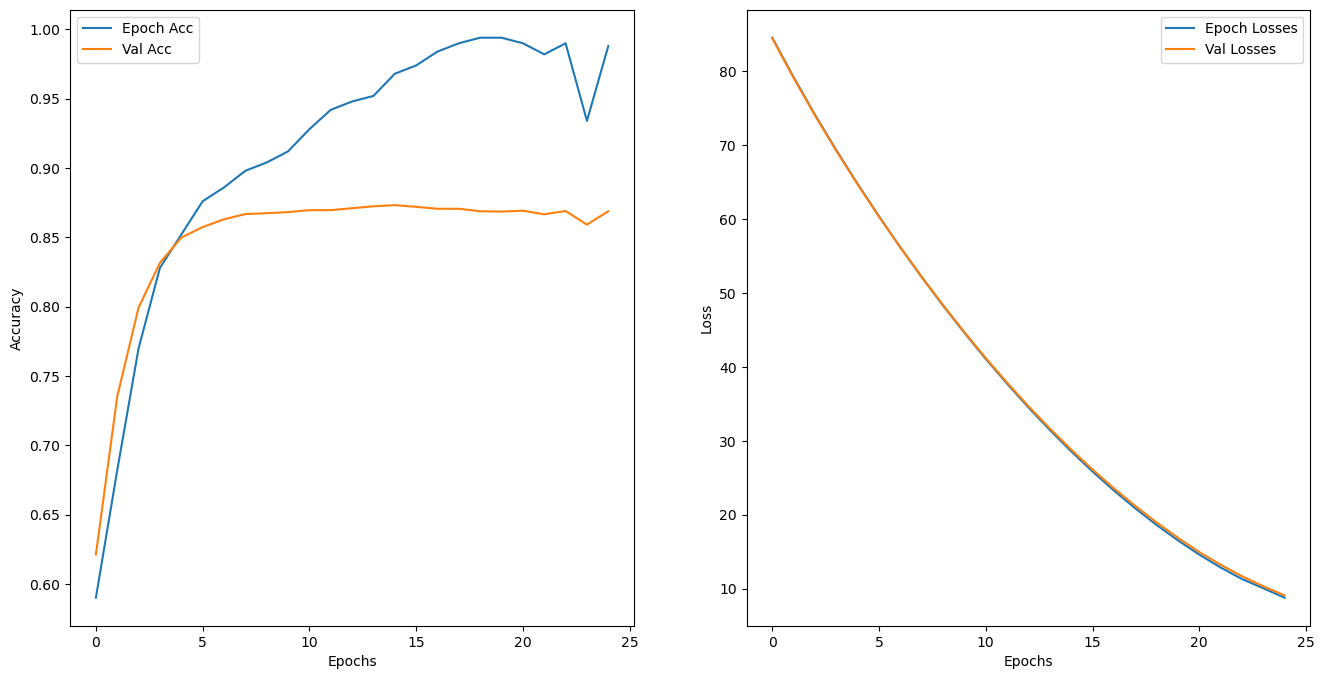

In [ ]:
plot_scores(scores1)


Train MLP 2

In [ ]:
scores2 = train_mlp(mlp2,batch_size=500)

MLP - epoch: 1, training acc: 0.580, training loss: 84.611, validation acc: 0.602, validation loss: 84.544
MLP - epoch: 2, training acc: 0.706, training loss: 79.239, validation acc: 0.739, validation loss: 79.159
MLP - epoch: 3, training acc: 0.788, training loss: 74.145, validation acc: 0.809, validation loss: 74.053
MLP - epoch: 4, training acc: 0.846, training loss: 69.359, validation acc: 0.837, validation loss: 69.285
MLP - epoch: 5, training acc: 0.872, training loss: 64.805, validation acc: 0.850, validation loss: 64.752
MLP - epoch: 6, training acc: 0.886, training loss: 60.450, validation acc: 0.860, validation loss: 60.419
MLP - epoch: 7, training acc: 0.896, training loss: 56.274, validation acc: 0.866, validation loss: 56.269
MLP - epoch: 8, training acc: 0.900, training loss: 52.271, validation acc: 0.870, validation loss: 52.292
MLP - epoch: 9, training acc: 0.906, training loss: 48.433, validation acc: 0.872, validation loss: 48.484
MLP - epoch: 10, training acc: 0.922,

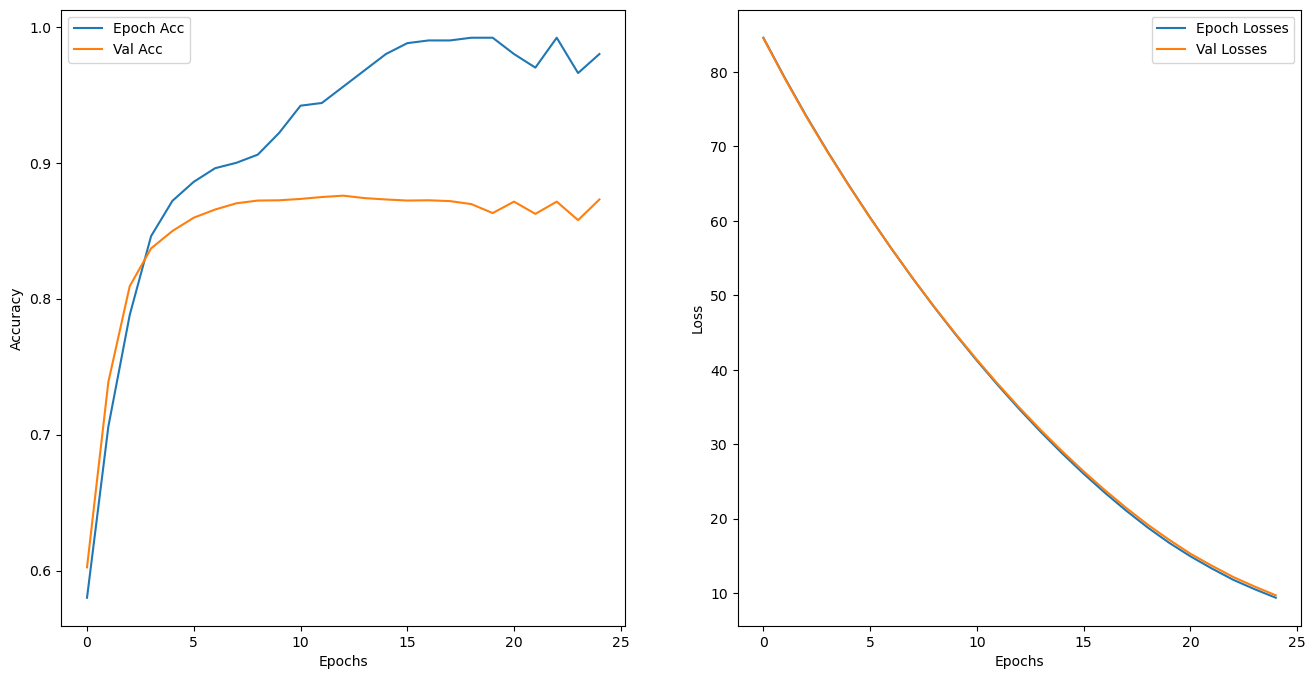

In [ ]:
plot_scores(scores2)

Test

In [ ]:
def confusion_matrix(y_pred,y_test=y_test):
  tp = 0
  fp = 0
  fn = 0
  tn = 0
  for i in range(len(y_pred)):
    #print(y_pred[i][0],y_test[i][0])
    if(y_pred[i][0]>0 and y_test[i][0]==1):
      tp+=1
    elif(y_pred[i][0]<0 and y_test[i][0]==0):
      tn+=1
    elif(y_pred[i][0]>0 and y_test[i][0]==0):
      fp+=1
    elif(y_pred[i][0]<0 and y_test[i][0]==1):
      fn+=1
  print(f"\tTP:{tp}\tFP:{fp}")
  print(f"\tFN:{fn}\tTN:{tn}")
  #print((tp+tn)/(tp+tn+fp+fn))


In [ ]:
mlp1_y_test_preds = mlp1.forward(X_test)
mlp2_y_test_preds = mlp2.forward(X_test)
mlp1_y_predictions = np.argmax(mlp1_y_test_preds, axis=1)
mlp2_y_predictions = np.argmax(mlp2_y_test_preds, axis=1)
y_true = np.argmax(y_test, axis=1)
mlp1_test_accuracy = (mlp1_y_predictions==y_true)
mlp2_test_accuracy = (mlp2_y_predictions==y_true)
print("MLP1 Test Accuracy: ",np.mean(mlp1_test_accuracy))
print("MLP1 Confusion Matrix: ")
confusion_matrix(mlp1_y_test_preds)
print("MLP2 Test Accuracy: ",np.mean(mlp2_test_accuracy))
print("MLP2 Confusion Matrix: ")
confusion_matrix(mlp2_y_test_preds)

MLP1 Test Accuracy:  0.87
MLP1 Confusion Matrix: 
	TP:2213	FP:332
	FN:317	TN:2138
MLP2 Test Accuracy:  0.8648
MLP2 Confusion Matrix: 
	TP:2141	FP:281
	FN:389	TN:2189


Experimental Evaluation

In [ ]:
mlp1_experiment = []
mlp2_experiment = []
y_true = np.argmax(y_test, axis=1)
for i in range(10):
  print(i)
  mlp1_exp = MLP_1(size_input, 96, 96, 96, 96, size_output,learning_rate,seed=i, device='gpu')
  mlp2_exp = MLP_2(size_input, 96, 96, 96, 96, 96, size_output,learning_rate, seed=i, device='gpu')
  train_mlp(mlp1_exp,batch_size=500)
  train_mlp(mlp2_exp,batch_size=500)
  mlp1_y_test_preds = mlp1_exp.forward(X_test)
  mlp2_y_test_preds = mlp2_exp.forward(X_test)
  mlp1_y_predictions = np.argmax(mlp1_y_test_preds, axis=1)
  mlp2_y_predictions = np.argmax(mlp2_y_test_preds, axis=1)
  mlp1_test_accuracy = (mlp1_y_predictions==y_true)
  mlp2_test_accuracy = (mlp2_y_predictions==y_true)
  mlp1_experiment.append(np.mean(mlp1_test_accuracy))
  mlp2_experiment.append(np.mean(mlp2_test_accuracy))
print("DONE RUNNING EXPERIMENT")

0
MLP - epoch: 1, training acc: 0.590, training loss: 87.347, validation acc: 0.587, validation loss: 87.281
MLP - epoch: 2, training acc: 0.639, training loss: 84.592, validation acc: 0.666, validation loss: 84.527
MLP - epoch: 3, training acc: 0.705, training loss: 81.865, validation acc: 0.727, validation loss: 81.800
MLP - epoch: 4, training acc: 0.760, training loss: 79.210, validation acc: 0.776, validation loss: 79.149
MLP - epoch: 5, training acc: 0.790, training loss: 76.642, validation acc: 0.802, validation loss: 76.591
MLP - epoch: 6, training acc: 0.822, training loss: 74.147, validation acc: 0.817, validation loss: 74.108
MLP - epoch: 7, training acc: 0.841, training loss: 71.713, validation acc: 0.826, validation loss: 71.689
MLP - epoch: 8, training acc: 0.857, training loss: 69.334, validation acc: 0.834, validation loss: 69.325
MLP - epoch: 9, training acc: 0.870, training loss: 67.007, validation acc: 0.840, validation loss: 67.014
MLP - epoch: 10, training acc: 0.87

In [ ]:
print("MLP1 With Different Seeds Ran 10 times: ",mlp1_experiment)
print(f"MLP1 Mean: {np.mean(mlp1_experiment):.3f}\t MLP1 Stdev: {np.std(mlp1_experiment):.4f}")
print("MLP2 With Different Seeds Ran 10 times: ",mlp2_experiment)
print(f"MLP2 Mean: {np.mean(mlp2_experiment):.3f}\t MLP2 Stdev: {np.std(mlp2_experiment):.4f}")

MLP1 With Different Seeds Ran 10 times:  [0.8642, 0.8602, 0.8654, 0.8654, 0.8686, 0.862, 0.864, 0.867, 0.8602, 0.8684]
MLP1 Mean: 0.865	 MLP1 Stdev: 0.0029
MLP2 With Different Seeds Ran 10 times:  [0.8568, 0.8558, 0.8592, 0.8582, 0.867, 0.8542, 0.8586, 0.8576, 0.8572, 0.853]
MLP2 Mean: 0.858	 MLP2 Stdev: 0.0036
